In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, binom

plt.style.use('ggplot')

### 1. Introduction 

Does 4 out of 10 or 300 out of 1000 sound greater? We obviously would say 4/10 at first, but if we were a baseball recruiter trying to decide which of two potential players is expected to be a better batter, it's much more difficult to decide.  We can use the method of *empirical Bayes estimation*.  when deciding a large number of proportions.  For example, we might have the following: 

- **An ad campaign**: Which ads have higher click-through? 
- **A user on a site**: What fraction of user visits are to a particular part of the site? 

When dealing with pairs of successes/totals, it's easy to get tripped up by uncertainty in low counts.  1/2 is not the same as 50/100! 

### 2. Lahman Dataset

We'll use the Lahman batting dataset to demonstrate this: 

In [2]:
# Load Lahman batting dataset
batting = pd.read_csv('batting.csv')
batting.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


In [7]:
# Filter dataset
batting = batting[batting['AB'] > 0]
batting_new = batting.groupby('playerID')[['H', 'AB']].sum()
batting_new['average'] = batting_new['H'] / batting_new['AB']
batting_new.head()

,H,AB,average
playerID,,,
aardsda01,0,4,0.000000
aaronha01,3771,12364,0.304998
aaronto01,216,944,0.228814
aasedo01,0,5,0.000000
abadan01,2,21,0.095238


### 3. Estimate a Prior

The first step of empirical Bayes estimation is to estimate a beta prior using this data.  If we have a lot of observations, we can get a good estimate that doesn't depend much on any one individual.  Empirical Bayes is an *approximation* to more exact Bayesian methods.  Let's check and see what our distribution looks like for players with more than 500 at-bats: 

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


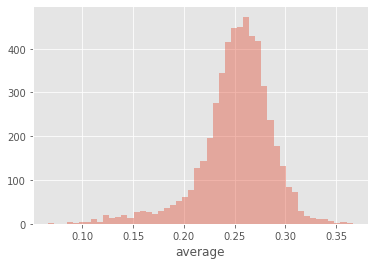

In [11]:
# Histogram of players with over 500 at-bats
over_500 = batting_new[batting_new['AB'] > 500]
sns.distplot(over_500['average'], kde=False);

This plot includes pitchers, so it looks slightly different at the tails compared to the one in the book, since many pitchers have lower-than-average batting averages.  In any case, we can use a beta distribution for our prior here.  We want to fit the following model: 

X ~ Beta($\alpha_{0}, \beta_{0}$)

We just need to pick an alpha and beta to serve as our "hyperparameters", which we can find by using maximum likelihood estimation: 

In [12]:
from scipy.special import gammaln

def loglike_betabinom(params, *args):

    a, b = params[0], params[1]
    k = args[0] # the OVERALL conversions
    n = args[1] # the number of at-bats (AE)

    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

    return -np.sum(logpdf) 

In [13]:
from scipy.optimize import minimize

init_params = [1, 10]
# note that I am putting 'H' in the args
res = minimize(loglike_betabinom, x0=init_params,
            args=(over_500['H'], over_500['AB']),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 250})
print(res)

      fun: 30175.446679895696
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.23210305, -0.24374458])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 165
      nit: 23
   status: 0
  success: True
        x: array([ 42.89932688, 126.90132552])


In [22]:
# Save alpha_0 and beta_0
alpha_0 = 42.899
beta_0 = 126.901

Let's check these parameters: 

In [14]:
def plot_beta(x_range, a, b, mu=0, sigma=1, cdf=False, **kwargs):
    x = x_range
    if cdf:
        y = beta.cdf(x, a, b, mu, sigma)
    else: 
        y = beta.pdf(x, a, b, mu, sigma)
    plt.plot(x, y, **kwargs)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


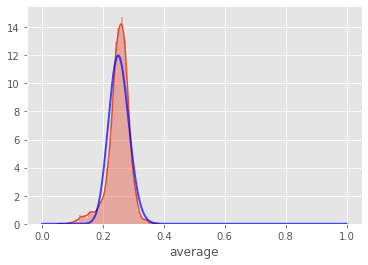

In [20]:
# Plot beta distribution with alpha = 42.899 and beta = 126.901
sns.distplot(over_500['average'])

x = np.linspace(0, 1, 5000)
plot_beta(x, 42.899, 126.901, 0, 1, color='blue', lw=2, ls='-', alpha=0.7)
plt.show()

So this matches fairly well!

### 4. Use Distribution as a Prior for Individual Estimates

When we look at any individual to estimate batting average, we start with the overall prior and update based on individual evidence.  It's as simple as adding values to alpha and beta that we start with.  Let's create a new column called `eb_estimates` that contains this calculation: 

In [23]:
# Create eb_estimates column
batting_new['eb_estimate'] = (batting_new['H'] + alpha_0) / (batting_new['AB'] + alpha_0 + beta_0)
batting_new.head()

,H,AB,average,eb_estimate
playerID,,,,
aardsda01,0,4,0.000000,0.246830
aaronha01,3771,12364,0.304998,0.304289
aaronto01,216,944,0.228814,0.232447
aasedo01,0,5,0.000000,0.245418
abadan01,2,21,0.095238,0.235320


Now that we finally have this, we can have a much better answer to the question "who are the best and worst batters in the league?": 

In [27]:
# Get top 5 best batters
batting_new.sort_values(by=['eb_estimate']).tail(5)

,H,AB,average,eb_estimate
playerID,,,,
meyerle01,513,1443,0.355509,0.344679
jacksjo01,1772,4981,0.355752,0.352353
barnero01,860,2391,0.359682,0.352585
hornsro01,2930,8173,0.358497,0.356343
cobbty01,4189,11436,0.366299,0.364637


In [28]:
# Get top 5 worst batters
batting_new.sort_values(by=['eb_estimate']).head(5)

,H,AB,average,eb_estimate
playerID,,,,
chancde01,44,662,0.066465,0.104471
buhlbo01,76,857,0.088681,0.115796
ellswdi01,59,673,0.087667,0.120905
sheetbe01,34,449,0.075724,0.124271
handsbi01,37,472,0.078390,0.124492


The great thing about our empirical Bayes estimates is that we can now use them for down-stream analyses and not worry anymore about if a case with 0/1 or 1/1 or something ruins anything! 

### 5. Conclusion

There are two steps in any empirical Bayes estimation: 

- 1. Estimate the overall distribution of the data
- 2. Use that distribution as the prior for estimating each average 

In step 1, we just used maximum likelihood estimation to come up with values for alpha and beta that best fit our data.  In step 2, because we're using the beta and binomial, we just add successes to alpha and misses to the total, which took almost no time at all to compute.  